In [1]:
# Some helper sites:
# https://hoomd-blue.readthedocs.io/en/stable/
# https://freud.readthedocs.io/en/stable/examples/module_intros/Density-RDF-BinWidth.html
# https://nbviewer.jupyter.org/github/joaander/hoomd-examples/blob/master/Analysis%20-%20Accessing%20system%20configurations%20in%20python.ipynb
# https://nbviewer.jupyter.org/github/joaander/hoomd-examples/blob/master/Analysis%20-%20Quantitative%20-%20Online%20analysis%20with%20Freud.ipynb

#Bring in our old favorites.
import hoomd
import hoomd.md
import numpy
import freud #library for performing structural analysis
import matplotlib.pyplot as plt
%matplotlib inline 

# This is a helper class for automating RDF calculations with Freud
class rdf_analyze:
    def __init__(self, system):
        self.system = system;
        self.rdf = freud.density.RDF(rmax=4.0, dr=0.01); #Can update range and stepsize here
        
    def __call__(self, step):
        '''This special function defines what happens when we "register" the callback below'''
        snap = system.take_snapshot();
        pos = snap.particles.position;
        box = freud.box.Box(snap.box.Lx, snap.box.Ly, snap.box.Lz);
        self.rdf.accumulate(box, pos, pos);

In [4]:
hoomd.context.initialize("") #Turn on hoomd
system = hoomd.init.create_lattice(unitcell=hoomd.lattice.sc(a=1.2), n=7) #Initial config. Play with different sizes, pre-equilibrated configurations.
# Note: you can write out configurations with https://hoomd-blue.readthedocs.io/en/stable/module-hoomd-dump.html
# Note: And you can read  configurations with https://hoomd-blue.readthedocs.io/en/stable/module-hoomd-init.html
# Note: In concert, you can use these to start new simulations from old snapshots to skip the equilibration period of a job
analyzer = rdf_analyze(system); # Create the RDF analyzer using our class in the above cell
hoomd.analyze.callback(analyzer, period=100); #Registration of the RDF callback every 100 steps
nl = hoomd.md.nlist.cell() #Other neighbor lists you might play with include 'tree'
lj = hoomd.md.pair.lj(r_cut=2.5, nlist=nl) #Classic Lennard Jones. 
lj.pair_coeff.set('A', 'A', epsilon=1.0, sigma=1.0) #Classic Lennard Jones. No tinkering here!
hoomd.md.integrate.mode_standard(dt=0.005) #See how large of a step size you can get away with.
all = hoomd.group.all() #This will be 'boilerplate' for Project 2: always integrating all.
nvt = hoomd.md.integrate.nvt(group=all, kT=0.2, tau=.1) #Pick ensemble. Can try NPT with "high" P to equilibrate high densities.
nvt.randomize_velocities(seed=23) # Randomizing velocities speeds up equilibration.
hoomd.analyze.log(filename="log-output.log", quantities=['potential_energy', 'temperature'], period=100,overwrite=True) # get some observables!
hoomd.dump.gsd("trajectory.gsd", period=2e3, group=all, overwrite=True) # write out configurations periodically. Can skip if doing all analysis in real-time
hoomd.run(1e4) #make it go for this many steps


notice(2): Group "all" created containing 343 particles
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 343
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:05 | Step 10000 / 10000 | TPS 1735.29 | ETA 00:00:00
Average TPS: 1734.93
---------
-- Neighborlist stats:
317 normal updates / 100 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 84 / n_neigh_avg: 36.8426
shortest rebuild period: 16
-- Cell list stats:
Dimension: 2, 2, 2
n_min    : 6 / n_max: 75 / n_avg: 42.875
** run complete **


Text(0, 0.5, 'potential_energy')

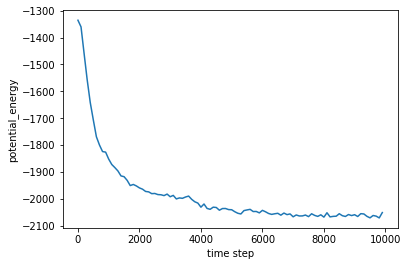

In [5]:
data = numpy.genfromtxt(fname='log-output.log', skip_header=True)
plt.plot(data[:,0], data[:,1]) #0th index is step, the other indices correspond to the order in which you specified the analyze.log
plt.xlabel('time step')
plt.ylabel('potential_energy') #1th index is pe because we put it first in log

Text(0, 0.5, 'g_AA')

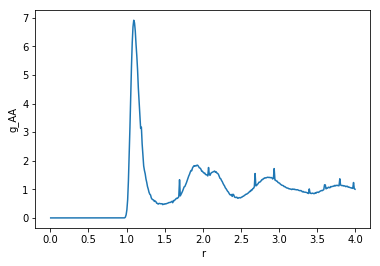

In [6]:
plt.plot(analyzer.rdf.R, analyzer.rdf.RDF) #use that accumulated RDF!
plt.xlabel('r')
plt.ylabel('g_AA')

In [7]:
# This cell defines machinery for rendering the pretty blue visualizations inline
# You might choose to move this up into the first (or make a new second) cell
# If you think you'll be using it a lot.
import fresnel
import gsd
import gsd.fl
import gsd.hoomd
import numpy
import PIL
import IPython
import io
import math
import sys

device = fresnel.Device(mode='cpu');
preview_tracer = fresnel.tracer.Preview(device, 300, 300, aa_level=3)
path_tracer = fresnel.tracer.Path(device, 300, 300)

blue = fresnel.color.linear([0.25,0.5,1])*0.9;
orange = fresnel.color.linear([1.0,0.714,0.169])*0.9

def render_sphere_frame(frame, height=None):

    if height is None:
        if hasattr(frame, 'configuration'):
            Ly = frame.configuration.box[1]
            height = Ly * math.sqrt(3)
        else:
            Ly = frame.box.Ly;
            height = Ly * math.sqrt(3)

    scene = fresnel.Scene(device)
    scene.lights = fresnel.light.cloudy();
    g = fresnel.geometry.Sphere(scene, position=frame.particles.position, radius=numpy.ones(frame.particles.N)*0.5)
    g.material = fresnel.material.Material(solid=0.0, color=blue, primitive_color_mix=1.0, specular=1.0, roughness=0.2)
    g.outline_width = 0.07
    scene.camera = fresnel.camera.orthographic(position=(height, height, height), look_at=(0,0,0), up=(0,1,0), height=height)

    g.color[frame.particles.typeid == 0] = blue;
    g.color[frame.particles.typeid == 1] = orange;

    scene.background_color = (1,1,1)

    return path_tracer.sample(scene, samples=64, light_samples=20)

def display_movie(frame_gen, gsd_file):
    f = gsd.fl.GSDFile(gsd_file, 'rb')
    t = gsd.hoomd.HOOMDTrajectory(f)

    a = frame_gen(t[0]);

    if tuple(map(int, (PIL.__version__.split(".")))) < (3,4,0):
        print("Warning! Movie display output requires pillow 3.4.0 or newer.")
        print("Older versions of pillow may only display the first frame.")

    im0 = PIL.Image.fromarray(a[:,:, 0:3], mode='RGB').convert("P", palette=PIL.Image.ADAPTIVE);
    ims = [];
    for f in t[1:]:
        a = frame_gen(f);
        im = PIL.Image.fromarray(a[:,:, 0:3], mode='RGB')
        im_p = im.quantize(palette=im0);
        ims.append(im_p)

    f = io.BytesIO()
    im0.save(f, 'gif', save_all=True, append_images=ims, duration=1000, loop=0)

    if (sys.version_info[0] >= 3):
        size = len(f.getbuffer())/1024;
        if (size > 2000):
            print("Size:", size, "KiB")
    return IPython.display.display(IPython.display.Image(data=f.getvalue()))


/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


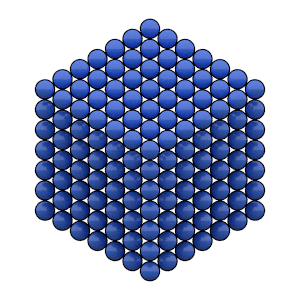

In [8]:
#Can take a bit of time to read in the trajectory and render it. Be patient!
display_movie(render_sphere_frame, 'trajectory.gsd');